In [1]:
# Import, Preprocess
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api


# Base Model Structures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU

# Model Modifications
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

# Evaluation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import time

# Plotting
import matplotlib.pyplot as plt

C:\Users\nicol\miniconda3\envs\GPU\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Load the data 

In [3]:
X_train = pd.read_csv("../data/X_train.csv")
X_test = pd.read_csv("../data/X_test.csv")
y_train = pd.read_csv("../data/y_train.csv")
y_test = pd.read_csv("../data/y_test.csv")

X_train = X_train.text 
X_test = X_test.text
y_train = y_train.Dominance.astype('category')
y_test = y_test.Dominance.astype('category')

# Pre-processing

## Load word2Vec embeddings

In [4]:
word2vec_model = api.load("word2vec-google-news-300")

In [5]:
# Preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
max_len = 100
X_train_pad = pad_sequences(X_train_sequences, maxlen=max_len)

# Encode labels
label_encoder = LabelEncoder()
y_train_lab = label_encoder.fit_transform(y_train)

In [6]:
X_test_sequences = tokenizer.texts_to_sequences(X_test) 
X_test_pad = pad_sequences(X_test_sequences, maxlen=max_len)

y_test_lab = label_encoder.transform(y_test)

In [7]:
# Create the embedding matrix
embedding_dim = 300  # Dimension of Word2Vec vectors
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with Word2Vec vectors
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        # If the word is not in the Word2Vec vocabulary, leave it as zero vector
        continue

## Test a model

In [8]:
def runModel(model_name, model, X_train, y_train, X_test, y_test, label_encoder, epochs=12, batch_size=256): 
    tf.random.set_seed(2319)
    start_time = time.time()
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

    end_time = time.time()

    total_time = (end_time - start_time)
    
    y_pred = model.predict(X_test)
    
    y_pred = np.argmax(y_pred, axis=1)
    
    p,r,f,s = precision_recall_fscore_support(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    dominance_results = pd.DataFrame({
                           'Precision':p,
                           'Recall':r, 
                           'F1': f, 
                           "Support": s})
    
    macro_scores = dominance_results.loc[:, ["Precision", "Recall", "F1"]].agg('mean')
    
    results = pd.DataFrame({'Model': [model_name], 
                           'Accuracy': [acc], 
                            'Precision': [macro_scores.Precision], 
                            'Recall': [macro_scores.Recall], 
                            'F1': [macro_scores.F1],
                            'Training_Time': [total_time]
                           })
    return results, history


def plot_loss(model_hist): 
    loss = model_hist.history['loss']
    val_loss = model_hist.history['val_loss']
    
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Model Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

## Build and Run Models 

## GRU

Epoch 1/12
83/83 [==============================] - 5s 13ms/step - loss: 2.5863 - accuracy: 0.2862 - val_loss: 2.1222 - val_accuracy: 0.4123
Epoch 2/12
83/83 [==============================] - 1s 10ms/step - loss: 1.7290 - accuracy: 0.5171 - val_loss: 1.4570 - val_accuracy: 0.5953
Epoch 3/12
83/83 [==============================] - 1s 10ms/step - loss: 1.2726 - accuracy: 0.6407 - val_loss: 1.2284 - val_accuracy: 0.6567
Epoch 4/12
83/83 [==============================] - 1s 10ms/step - loss: 1.0924 - accuracy: 0.6805 - val_loss: 1.1065 - val_accuracy: 0.6793
Epoch 5/12
83/83 [==============================] - 1s 10ms/step - loss: 0.9967 - accuracy: 0.7039 - val_loss: 1.0466 - val_accuracy: 0.6975
Epoch 6/12
83/83 [==============================] - 1s 10ms/step - loss: 0.9324 - accuracy: 0.7185 - val_loss: 1.0118 - val_accuracy: 0.6977
Epoch 7/12
83/83 [==============================] - 1s 11ms/step - loss: 0.8831 - accuracy: 0.7314 - val_loss: 0.9774 - val_accuracy: 0.7100
Epoch 8/12
83

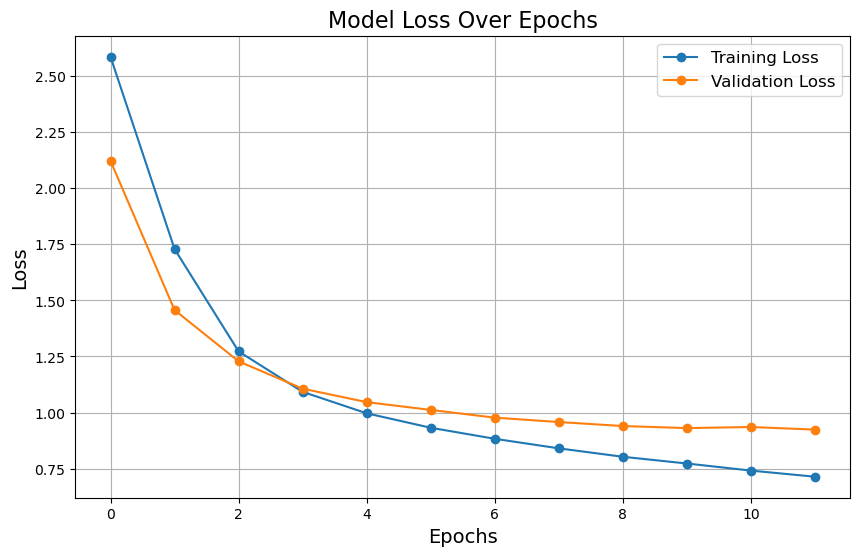

In [9]:
gru = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru.add(GRU(100))

gru.add(Dense(24, activation='softmax'))
gru.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_results, gru_history = runModel(
    model_name="GRU", 
    model=gru, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_history)

# GRU Dropout 

Epoch 1/12
83/83 [==============================] - 2s 14ms/step - loss: 2.6613 - accuracy: 0.2645 - val_loss: 2.2131 - val_accuracy: 0.3853
Epoch 2/12
83/83 [==============================] - 1s 11ms/step - loss: 1.9171 - accuracy: 0.4654 - val_loss: 1.6076 - val_accuracy: 0.5431
Epoch 3/12
83/83 [==============================] - 1s 11ms/step - loss: 1.4318 - accuracy: 0.5998 - val_loss: 1.2992 - val_accuracy: 0.6420
Epoch 4/12
83/83 [==============================] - 1s 11ms/step - loss: 1.2149 - accuracy: 0.6508 - val_loss: 1.1490 - val_accuracy: 0.6684
Epoch 5/12
83/83 [==============================] - 1s 11ms/step - loss: 1.0987 - accuracy: 0.6802 - val_loss: 1.0758 - val_accuracy: 0.6878
Epoch 6/12
83/83 [==============================] - 1s 11ms/step - loss: 1.0350 - accuracy: 0.6934 - val_loss: 1.0331 - val_accuracy: 0.6969
Epoch 7/12
83/83 [==============================] - 1s 11ms/step - loss: 0.9861 - accuracy: 0.7071 - val_loss: 0.9944 - val_accuracy: 0.7009
Epoch 8/12
83

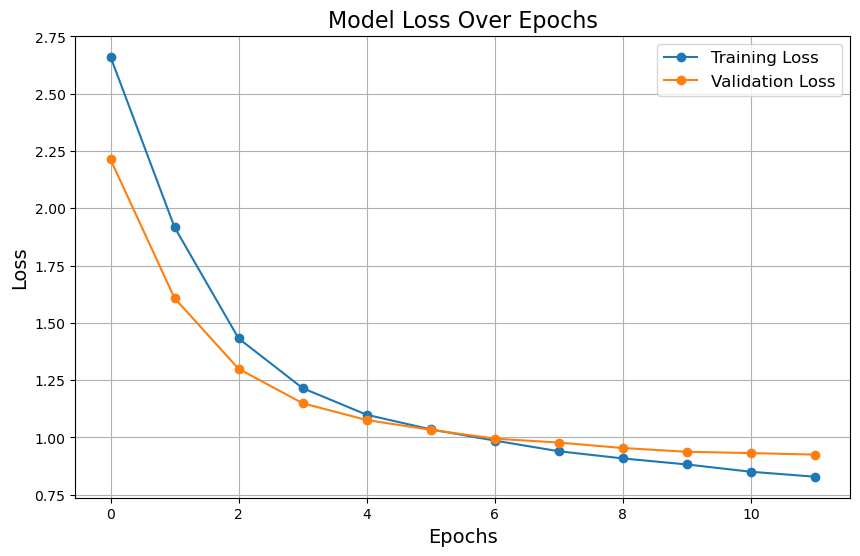

In [10]:
gru_drop = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_drop.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_drop.add(Dropout(0.2))
gru_drop.add(GRU(100))
gru_drop.add(Dropout(0.2))

gru_drop.add(Dense(24, activation='softmax'))
gru_drop.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_drop_results, gru_drop_history = runModel(
    model_name="GRU Dropout", 
    model=gru_drop, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_drop_history)

# GRU-CNN

Epoch 1/12
83/83 [==============================] - 4s 13ms/step - loss: 2.6727 - accuracy: 0.2419 - val_loss: 2.1630 - val_accuracy: 0.3982
Epoch 2/12
83/83 [==============================] - 1s 8ms/step - loss: 1.6664 - accuracy: 0.5265 - val_loss: 1.4406 - val_accuracy: 0.5851
Epoch 3/12
83/83 [==============================] - 1s 7ms/step - loss: 1.2862 - accuracy: 0.6298 - val_loss: 1.2533 - val_accuracy: 0.6379
Epoch 4/12
83/83 [==============================] - 1s 7ms/step - loss: 1.1218 - accuracy: 0.6721 - val_loss: 1.1587 - val_accuracy: 0.6629
Epoch 5/12
83/83 [==============================] - 1s 7ms/step - loss: 1.0193 - accuracy: 0.6948 - val_loss: 1.0843 - val_accuracy: 0.6817
Epoch 6/12
83/83 [==============================] - 1s 7ms/step - loss: 0.9523 - accuracy: 0.7148 - val_loss: 1.0527 - val_accuracy: 0.6905
Epoch 7/12
83/83 [==============================] - 1s 7ms/step - loss: 0.8935 - accuracy: 0.7294 - val_loss: 1.0227 - val_accuracy: 0.6983
Epoch 8/12
83/83 [=

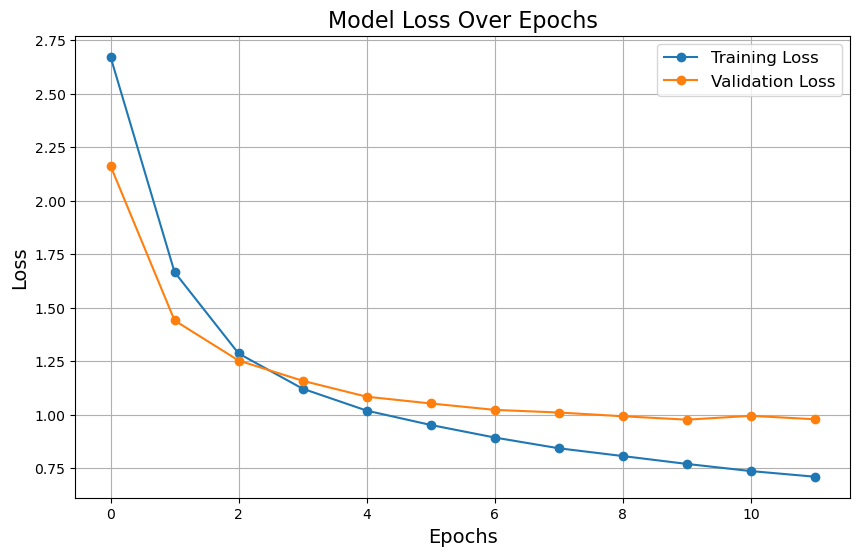

In [11]:
gru_cnn = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_cnn.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
gru_cnn.add(MaxPooling1D(pool_size=2))
gru_cnn.add(GRU(100))

gru_cnn.add(Dense(24, activation='softmax'))
gru_cnn.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_cnn_results, gru_cnn_history = runModel(
    model_name="GRU-CNN", 
    model=gru_cnn, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_cnn_history)

# Bi-GRU

Epoch 1/12
83/83 [==============================] - 3s 22ms/step - loss: 2.6492 - accuracy: 0.2568 - val_loss: 2.2281 - val_accuracy: 0.3826
Epoch 2/12
83/83 [==============================] - 2s 19ms/step - loss: 1.8051 - accuracy: 0.5012 - val_loss: 1.4906 - val_accuracy: 0.5883
Epoch 3/12
83/83 [==============================] - 2s 19ms/step - loss: 1.2969 - accuracy: 0.6315 - val_loss: 1.2481 - val_accuracy: 0.6443
Epoch 4/12
83/83 [==============================] - 2s 19ms/step - loss: 1.1102 - accuracy: 0.6755 - val_loss: 1.1362 - val_accuracy: 0.6701
Epoch 5/12
83/83 [==============================] - 2s 20ms/step - loss: 1.0086 - accuracy: 0.7003 - val_loss: 1.0657 - val_accuracy: 0.6867
Epoch 6/12
83/83 [==============================] - 2s 18ms/step - loss: 0.9385 - accuracy: 0.7151 - val_loss: 1.0278 - val_accuracy: 0.6965
Epoch 7/12
83/83 [==============================] - 2s 19ms/step - loss: 0.8820 - accuracy: 0.7331 - val_loss: 0.9994 - val_accuracy: 0.6992
Epoch 8/12
83

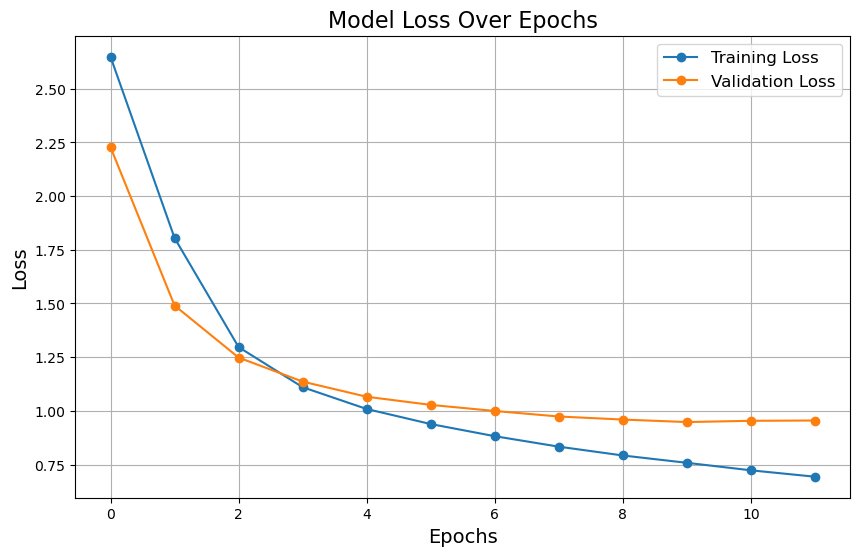

In [12]:
gru_bi = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_bi.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_bi.add(Bidirectional(GRU(100)))

gru_bi.add(Dense(24, activation='softmax'))
gru_bi.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_bi_results, gru_bi_history = runModel(
    model_name="Bi-GRU", 
    model=gru_bi, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_bi_history)

# GRU w/ CNN & Dropout

Epoch 1/12
83/83 [==============================] - 2s 10ms/step - loss: 2.6939 - accuracy: 0.2350 - val_loss: 2.1650 - val_accuracy: 0.3897
Epoch 2/12
83/83 [==============================] - 1s 8ms/step - loss: 1.8431 - accuracy: 0.4689 - val_loss: 1.4966 - val_accuracy: 0.5722
Epoch 3/12
83/83 [==============================] - 1s 8ms/step - loss: 1.4133 - accuracy: 0.5983 - val_loss: 1.2596 - val_accuracy: 0.6379
Epoch 4/12
83/83 [==============================] - 1s 8ms/step - loss: 1.2317 - accuracy: 0.6428 - val_loss: 1.1514 - val_accuracy: 0.6671
Epoch 5/12
83/83 [==============================] - 1s 8ms/step - loss: 1.1334 - accuracy: 0.6684 - val_loss: 1.0943 - val_accuracy: 0.6757
Epoch 6/12
83/83 [==============================] - 1s 8ms/step - loss: 1.0805 - accuracy: 0.6810 - val_loss: 1.0523 - val_accuracy: 0.6859
Epoch 7/12
83/83 [==============================] - 1s 8ms/step - loss: 1.0356 - accuracy: 0.6909 - val_loss: 1.0222 - val_accuracy: 0.6954
Epoch 8/12
83/83 [=

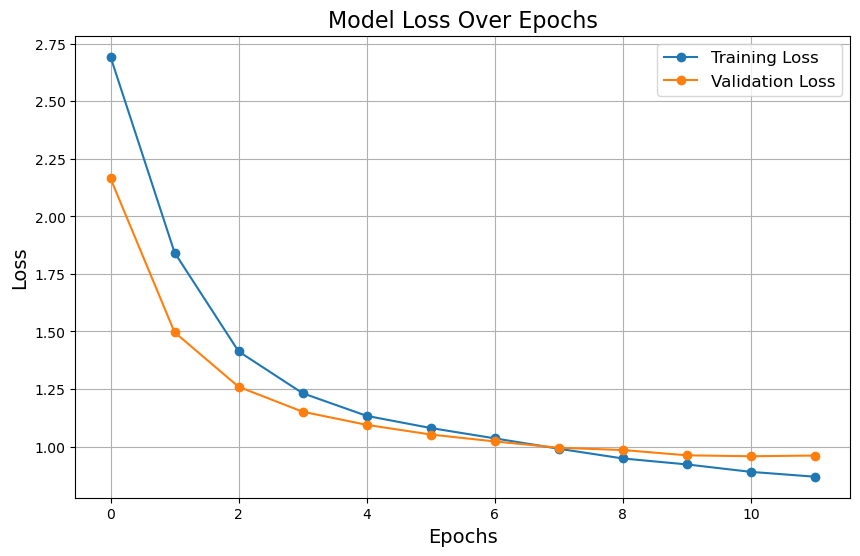

In [13]:
gru_cnn_drop = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_cnn_drop.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_cnn_drop.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
gru_cnn_drop.add(MaxPooling1D(pool_size=2))

gru_cnn_drop.add(Dropout(0.2))
gru_cnn_drop.add(GRU(100))
gru_cnn_drop.add(Dropout(0.2))

gru_cnn_drop.add(Dense(24, activation='softmax'))
gru_cnn_drop.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_cnn_drop_results, gru_cnn_drop_history = runModel(
    model_name="GRU-CNN-Dropout", 
    model=gru_cnn_drop, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_cnn_drop_history)

# GRU - CNN - Dropout - Bidirectional

Epoch 1/12
83/83 [==============================] - 3s 17ms/step - loss: 2.7160 - accuracy: 0.2260 - val_loss: 2.2376 - val_accuracy: 0.3618
Epoch 2/12
83/83 [==============================] - 1s 12ms/step - loss: 1.9006 - accuracy: 0.4518 - val_loss: 1.5662 - val_accuracy: 0.5642
Epoch 3/12
83/83 [==============================] - 1s 12ms/step - loss: 1.4518 - accuracy: 0.5888 - val_loss: 1.3150 - val_accuracy: 0.6253
Epoch 4/12
83/83 [==============================] - 1s 12ms/step - loss: 1.2600 - accuracy: 0.6382 - val_loss: 1.1907 - val_accuracy: 0.6599
Epoch 5/12
83/83 [==============================] - 1s 12ms/step - loss: 1.1639 - accuracy: 0.6596 - val_loss: 1.1231 - val_accuracy: 0.6747
Epoch 6/12
83/83 [==============================] - 1s 12ms/step - loss: 1.0954 - accuracy: 0.6766 - val_loss: 1.0798 - val_accuracy: 0.6819
Epoch 7/12
83/83 [==============================] - 1s 12ms/step - loss: 1.0422 - accuracy: 0.6912 - val_loss: 1.0498 - val_accuracy: 0.6931
Epoch 8/12
83

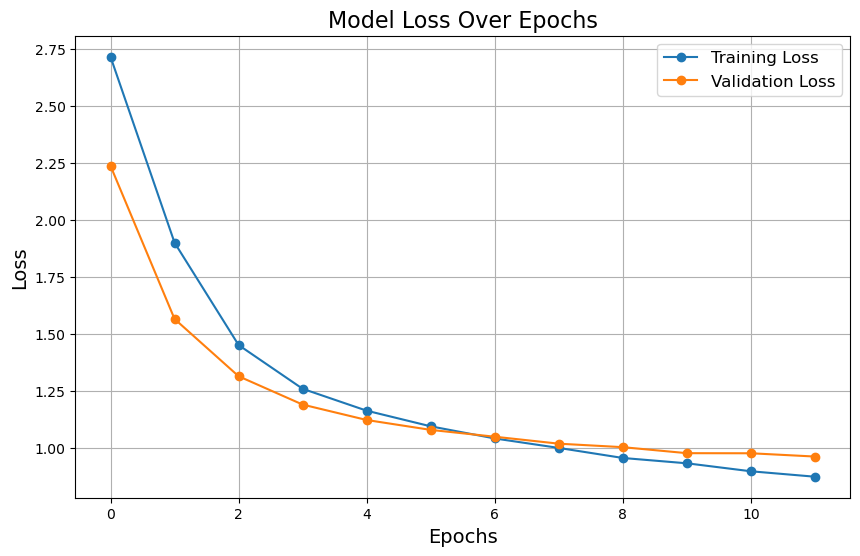

In [14]:
gru_cnn_drop_bi = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_cnn_drop_bi.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_cnn_drop_bi.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
gru_cnn_drop_bi.add(MaxPooling1D(pool_size=2))

gru_cnn_drop_bi.add(Dropout(0.2))
gru_cnn_drop_bi.add(Bidirectional(GRU(100)))
gru_cnn_drop_bi.add(Dropout(0.2))

gru_cnn_drop_bi.add(Dense(24, activation='softmax'))
gru_cnn_drop_bi.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_cnn_drop_bi_results, gru_cnn_drop_bi_history = runModel(
    model_name="GRU-CNN-Dropout-Bi", 
    model=gru_cnn_drop_bi, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_cnn_drop_bi_history)

# GRU - CNN - Dropout - V2

Epoch 1/12
83/83 [==============================] - 3s 18ms/step - loss: 2.7533 - accuracy: 0.1939 - val_loss: 2.2924 - val_accuracy: 0.3507
Epoch 2/12
83/83 [==============================] - 1s 13ms/step - loss: 2.1015 - accuracy: 0.3830 - val_loss: 1.8099 - val_accuracy: 0.4878
Epoch 3/12
83/83 [==============================] - 1s 13ms/step - loss: 1.7801 - accuracy: 0.4825 - val_loss: 1.5573 - val_accuracy: 0.5680
Epoch 4/12
83/83 [==============================] - 1s 13ms/step - loss: 1.5404 - accuracy: 0.5666 - val_loss: 1.3928 - val_accuracy: 0.6246
Epoch 5/12
83/83 [==============================] - 1s 13ms/step - loss: 1.3949 - accuracy: 0.6105 - val_loss: 1.2944 - val_accuracy: 0.6441
Epoch 6/12
83/83 [==============================] - 1s 13ms/step - loss: 1.2892 - accuracy: 0.6412 - val_loss: 1.2364 - val_accuracy: 0.6591
Epoch 7/12
83/83 [==============================] - 1s 13ms/step - loss: 1.2201 - accuracy: 0.6618 - val_loss: 1.2193 - val_accuracy: 0.6700
Epoch 8/12
83

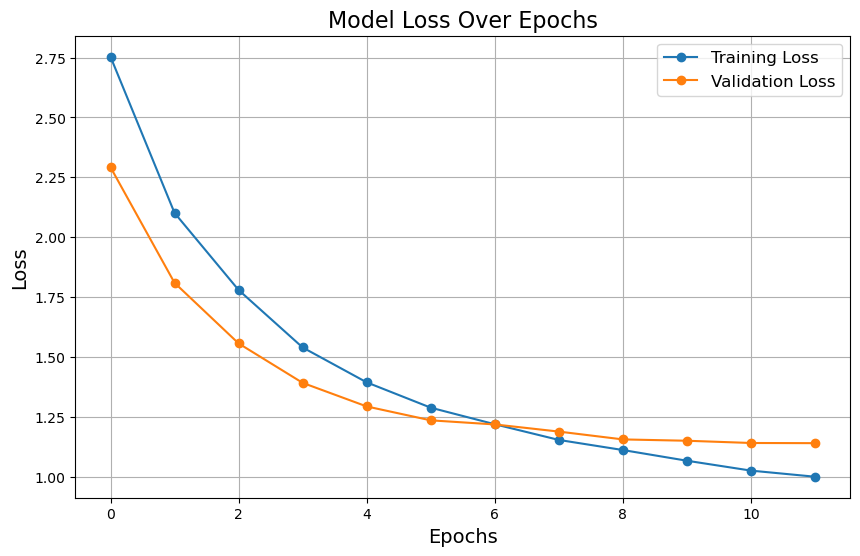

In [15]:
gru_cnn_drop_2 = Sequential()

# Add the embedding layer initialized with Word2Vec embeddings
gru_cnn_drop_2.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_len, 
                    trainable=False))  # Set trainable=False to freeze the embeddings

gru_cnn_drop_2.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
gru_cnn_drop_2.add(MaxPooling1D(pool_size=2))

gru_cnn_drop_2.add(Dropout(0.2))
gru_cnn_drop_2.add(GRU(128, return_sequences=True))
gru_cnn_drop_2.add(Dropout(0.2))

gru_cnn_drop_2.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
gru_cnn_drop_2.add(MaxPooling1D(pool_size=2))

gru_cnn_drop_2.add(Dropout(0.2))
gru_cnn_drop_2.add(GRU(64))
gru_cnn_drop_2.add(Dropout(0.2))

gru_cnn_drop_2.add(Dense(24, activation='softmax'))
gru_cnn_drop_2.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(), 
              metrics=['accuracy'])

gru_cnn_drop_2_results, gru_cnn_drop_2_history = runModel(
    model_name="GRU-CNN-Dropout-2", 
    model=gru_cnn_drop_2, 
    X_train=X_train_pad, 
    y_train=y_train_lab, 
    X_test=X_test_pad, 
    y_test=y_test_lab,
    label_encoder=label_encoder
)

plot_loss(gru_cnn_drop_2_history)

# Summary

In [16]:
summary = pd.concat([gru_results, 
                     gru_cnn_results,
                     gru_bi_results,
                     gru_drop_results,
                     gru_cnn_drop_results, 
                     gru_cnn_drop_bi_results,
                     gru_cnn_drop_2_results])
summary.sort_values('F1', ascending=False)

,Model,Accuracy,Precision,Recall,F1,Training_Time
0,GRU,0.724839,0.715181,0.688513,0.699032,14.087710
0,GRU Dropout,0.721610,0.717246,0.681015,0.695143,12.245166
0,Bi-GRU,0.714964,0.701285,0.677903,0.685870,20.333699
0,GRU-CNN-Dropout-Bi,0.716483,0.706222,0.666650,0.681422,13.721010
0,GRU-CNN-Dropout,0.712875,0.695925,0.671537,0.677312,8.696422
0,GRU-CNN,0.710027,0.694214,0.660224,0.672691,10.595832
0,GRU-CNN-Dropout-2,0.690657,0.665715,0.620313,0.629874,15.038651
